In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, utils, callbacks, metrics

import cv2
tf.__version__

'2.2.0'

In [2]:
# 吃路徑的方式開檔案
# FOLDER_PATH = '/content/drive/My Drive/class/勞動部/week12/ECG'
# df = pd.read_csv(os.path.join(FOLDER_PATH, 'mitbih.csv'), header=None)
# num_classes=5

# 把檔案放入 google dirve 內直接開
df = pd.read_csv("mitbih.csv")
num_classes = 5

In [3]:
df.head()

,0.9248658418655396,0.9928443431854248,0.5366726517677307,0.1824686974287033,0.09481216222047804,0.051878355443477624,0.03577817603945732,0.06082289665937424,0.09302325546741486,0.18783542513847354,0.3398926556110382,0.4275491833686829,0.4722719192504882,0.4740608334541321,0.4132379293441773,0.4704830050468445,0.4758497178554535,0.4686940908432007,0.44722718000411993,0.44722718000411993.1,0.44722718000411993.2,0.4311270117759705,0.39892664551734924,0.39713773131370544,0.41502684354782093,0.38998210430145264,0.3506261110305786,0.3649373948574066,0.381037563085556,0.381037563085556.1,0.3631484806537628,0.3881931900978087,0.40787118673324574,0.4382826387882233,0.4543828368186951,0.4794275462627411,0.4740608334541321.1,0.499105542898178,0.5205724239349364,0.5134168267250061,...,0.0.39,0.0.40,0.0.41,0.0.42,0.0.43,0.0.44,0.0.45,0.0.46,0.0.47,0.0.48,0.0.49,0.0.50,0.0.51,0.0.52,0.0.53,0.0.54,0.0.55,0.0.56,0.0.57,0.0.58,0.0.59,0.0.60,0.0.61,0.0.62,0.0.63,0.0.64,0.0.65,0.0.66,0.0.67,0.0.68,0.0.69,0.0.70,0.0.71,0.0.72,0.0.73,0.0.74,0.0.75,0.0.76,0.0.77,0.0.78
0,0.981324,0.964346,0.414261,0.005093,0.139219,0.293718,0.302207,0.288625,0.280136,0.276740,0.283531,0.290323,0.283531,0.280136,0.281834,0.292020,0.290323,0.285229,0.292020,0.298812,0.298812,0.293718,0.292020,0.305603,0.300509,0.295416,0.302207,0.302207,0.302207,0.303905,0.308998,0.315789,0.315789,0.317487,0.319185,0.331070,0.336163,0.336163,0.339559,0.346350,...,0.302207,0.295416,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.985486,0.804064,0.438316,0.158200,0.014514,0.074020,0.121916,0.088534,0.078374,0.092888,0.082729,0.068215,0.071118,0.075472,0.082729,0.088534,0.088534,0.100145,0.121916,0.133527,0.169811,0.197388,0.220610,0.252540,0.283019,0.325109,0.346880,0.361393,0.383164,0.397678,0.403483,0.396226,0.375907,0.370102,0.349782,0.330914,0.320755,0.297533,0.283019,0.264151,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.827320,0.755155,0.520619,0.271907,0.123711,0.059278,0.030928,0.001289,0.000000,0.039948,0.144330,0.244845,0.291237,0.311856,0.322165,0.362113,0.407216,0.442010,0.475515,0.501289,0.518041,0.530928,0.559278,0.590206,0.606959,0.644330,0.657216,0.690722,0.713918,0.747423,0.764175,0.786082,0.789948,0.798969,0.797680,0.788660,0.771907,0.759021,0.722938,0.695876,...,0.862113,0.608247,0.568299,0.565722,0.534794,0.502577,0.48067,0.45232,0.426546,0.417526,0.399485,0.393041,0.390464,0.385309,0.382732,0.386598,0.382732,0.378866,0.376289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.965517,0.620690,0.206897,0.187739,0.118774,0.009579,0.005747,0.095785,0.203065,0.258621,0.268199,0.273946,0.289272,0.293103,0.293103,0.302682,0.312261,0.312261,0.308429,0.316092,0.325671,0.329502,0.329502,0.340996,0.354406,0.356322,0.360153,0.371648,0.385057,0.394636,0.400383,0.421456,0.434866,0.452107,0.459770,0.471264,0.484674,0.492337,0.494253,0.503831,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.949153,0.815981,0.210654,0.000000,0.142857,0.244552,0.251816,0.259080,0.261501,0.261501,0.266344,0.285714,0.300242,0.300242,0.309927,0.324455,0.338983,0.353511,0.346247,0.382567,0.406780,0.423729,0.445521,0.447942,0.474576,0.476998,0.491525,0.486683,0.479419,0.472155,0.445521,0.440678,0.406780,0.394673,0.389830,0.368039,0.363196,0.358354,0.351090,0.336562,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000

In [4]:
df_train, df_val = train_test_split(df, test_size=0.2)

In [5]:
x_train = df_train.iloc[:, :-1]
x_train = np.expand_dims(x_train, axis=-1)
y_train = df_train.iloc[:, -1]

x_val = df_val.iloc[:, :-1]
x_val = np.expand_dims(x_val, axis=-1)
y_val = df_val.iloc[:, -1]

y_train = utils.to_categorical(y_train, num_classes=num_classes)
y_val = utils.to_categorical(y_val, num_classes=num_classes)

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1750, 187, 1), (1750, 5), (438, 187, 1), (438, 5))

In [7]:
# 查看 y_val 為 nparray
y_val

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

label:  [0. 0. 0. 1. 0.]


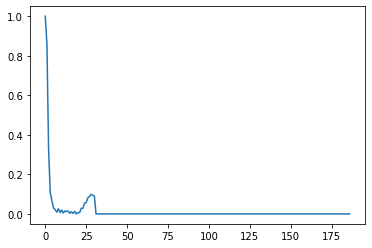

In [8]:
idx = 400
print('label: ', y_val[idx])
plt.plot(x_val[idx])

In [9]:
# 統計一下第 0個類別有 1468 筆資料, 依此類推
# 類別1 是正常情況, 有 1468筆, 類別2 是不正常的心電圖有 51筆, 各個類別的數量不平衡
# 這個模型自然而然會傾向於類別1的方向預測，解決方式是 把類別1 抽樣成跟其他數量差不多
# 
np.unique(np.argmax(y_train, axis=-1), return_counts=True), np.unique(np.argmax(y_val, axis=-1), return_counts=True)

((array([0, 1, 2, 3, 4]), array([1452,   52,  117,   16,  113])),
 (array([0, 1, 2, 3, 4]), array([369,  10,  18,   3,  38])))

In [12]:
# 計算個類別比重程度
per = []
for i in np.unique(np.argmax(y_train, axis=-1), return_counts=True)[1]:
  per.append( 1 // (i / np.sum(np.unique(np.argmax(y_train, axis=-1), return_counts=True)[1])))
per

[1.0, 33.0, 14.0, 109.0, 15.0]

In [13]:
# CNN 用 conv1D，心電圖訊號是1維訊號，X軸是時間，Y軸是電壓大小
# 轉成數值的方式去看，每一個時間點有電壓大小的數值
def build_model():
    inputs = layers.Input(shape=x_train.shape[1:])
    conv1_1 = layers.Conv1D(64, (6), activation='relu')(inputs)
    conv1_1 = layers.BatchNormalization()(conv1_1)
    pool1 = layers.Conv1D(64, 3, strides=(2), padding="same")(conv1_1)
    conv2_1 = layers.Conv1D(128, (3), activation='relu')(pool1)
    conv2_1 = layers.BatchNormalization()(conv2_1)
    pool2 = layers.Conv1D(128, 3, strides=(2), padding="same")(conv2_1)
    conv3_1 = layers.Conv1D(256, (3), activation='relu')(pool2)
    conv3_1 = layers.BatchNormalization()(conv3_1)
    pool3 = layers.Conv1D(256, 3, strides=(2), padding="same")(conv3_1)
    flatten = layers.Flatten()(pool3)
    dense_end1 = layers.Dense(64, activation='relu')(flatten)
    dense_end2 = layers.Dense(32, activation='relu')(dense_end1)
    main_output = layers.Dense(num_classes, activation='softmax', name='main_output')(dense_end2)
    
    model = models.Model(inputs, main_output)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [14]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 182, 64)           448       
_________________________________________________________________
batch_normalization (BatchNo (None, 182, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 64)            12352     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 128)           24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 89, 128)           512       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 45, 128)           49280 

In [15]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
            tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [16]:
# class_weight 可以讓每一個類別的比重吃多少，類別 2~4 的資料量太少，調整比率高一點
# 類別1 的資料量相較來講較多，所以調降資料比重
history = model.fit(x_train, 
                    y_train, 
                    epochs=1000,
                    callbacks=callback, 
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    # Weighting Loss function, 如上說明
                    class_weight={
                        0: per[0],
                        1: per[1],
                        2: per[2],
                        3: per[3],
                        4: per[4],
                    }
                    )

Epoch 1/1000
55/55 [==============================] - 1s 20ms/step - loss: 6.8167 - accuracy: 0.4731 - val_loss: 1.1888 - val_accuracy: 0.7968
Epoch 2/1000
55/55 [==============================] - 0s 7ms/step - loss: 4.5067 - accuracy: 0.5514 - val_loss: 2.1308 - val_accuracy: 0.0228
Epoch 3/1000
55/55 [==============================] - 0s 7ms/step - loss: 4.4977 - accuracy: 0.5766 - val_loss: 3.7093 - val_accuracy: 0.0228
Epoch 4/1000
55/55 [==============================] - 0s 7ms/step - loss: 3.5920 - accuracy: 0.6463 - val_loss: 6.1087 - val_accuracy: 0.0228
Epoch 5/1000
55/55 [==============================] - 0s 6ms/step - loss: 3.4585 - accuracy: 0.6943 - val_loss: 1.3803 - val_accuracy: 0.7009
Epoch 6/1000
55/55 [==============================] - 0s 7ms/step - loss: 3.1317 - accuracy: 0.7011 - val_loss: 1.6108 - val_accuracy: 0.3516
Epoch 7/1000
55/55 [==============================] - 0s 7ms/step - loss: 2.2751 - accuracy: 0.7051 - val_loss: 3.8582 - val_accuracy: 0.0434
Epoch

In [17]:
def cls_report(path):
  model = tf.keras.models.load_model(path)
  pred = np.argmax(model.predict(x_val), axis=-1)
  print(classification_report(np.argmax(y_val, axis=1), pred))

In [18]:
cls_report("best_model.h5")

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       369
           1       0.38      0.50      0.43        10
           2       0.68      0.83      0.75        18
           3       0.20      0.33      0.25         3
           4       1.00      0.79      0.88        38

    accuracy                           0.92       438
   macro avg       0.64      0.68      0.65       438
weighted avg       0.93      0.92      0.92       438



In [ ]:
# accuracy = 0.92